In [136]:

import numpy as np
from torch import nn
from PIL import Image, ImageOps
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
# from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.image as mpimg
from torch.utils.data import Dataset
import os
import torch.optim as optim
# from keras.applications.vgg16 import VGG16
import kagglehub
import shutil

import IPython
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm


In [137]:
class FolderDataset(Dataset):
    """
    Creates a PyTorch dataset from folder, returning two tensor images.
    Args: 
    main_dir : directory where images are stored.
    transform (optional) : torchvision transforms to be applied while making dataset
    """

    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = sorted(os.listdir(main_dir))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert('RGB') 

        if self.transform:
            tensor_image = self.transform(image)
        else: 
            print("transform is none")
    

        return tensor_image, tensor_image

In [138]:
class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        return x

In [139]:
class ConvDecoder(nn.Module):
    """
    A simple Convolutional Decoder Model
    """

    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
         # Upscale the image with convtranspose etc.
        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)
        return x

In [140]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    train_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    optimizer: PyTorch optimizer.
    device: "cuda" or "cpu"
    Returns: Train Loss
    """
    #  Set networks to train mode.
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        # Move images to device
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        # Zero grad the optimizer
        optimizer.zero_grad()
        # Feed the train images to encoder
        enc_output = encoder(train_img)
        # The output of encoder is input to decoder !
        dec_output = decoder(enc_output)
        
        # Decoder output is reconstructed image
        # Compute loss with it and orginal image which is target image.
        loss = loss_fn(dec_output, target_img)
        # Backpropogate
        loss.backward()
        # Apply the optimizer to network by calling step.
        optimizer.step()
    # Return the loss
    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    val_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    device: "cuda" or "cpu"
    Returns: Validation Loss
    """
    
    # Set to eval mode.
    encoder.eval()
    decoder.eval()
    
    # We don't need to compute gradients while validating.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            # Move to device
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # Again as train. Feed encoder the train image.
            enc_output = encoder(train_img)
            # Decoder takes encoder output and reconstructs the image.
            dec_output = decoder(enc_output)

            # Validation loss for encoder and decoder.
            loss = loss_fn(dec_output, target_img)
    # Return the loss
    return loss.item()

In [141]:
def create_embedding(encoder, full_loader, device):
    """
    Creates embedding using the encoder from a dataloader.
    Args:
      encoder: A convolutional Encoder.
      full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
      device: "cuda" or "cpu"
    Returns:
      Embedding tensor containing the outputs of the encoder for the full dataset.
    """
    encoder.eval()
    embeddings = []  # List to store outputs from each batch
    
    with torch.no_grad():
        for batch_idx, (train_img, _) in enumerate(full_loader):
            train_img = train_img.to(device)
            # Get encoder outputs and move to CPU
            enc_output = encoder(train_img).cpu()
            embeddings.append(enc_output)
    
    embedding = torch.cat(embeddings, dim=0)

    return embedding


In [142]:
import torch
import torchvision.transforms as T

transforms = T.Compose([T.Resize((256, 256)), T.ToTensor()]) # Normalize the pixels and convert to tensor.

full_dataset = FolderDataset("Photos-001", transforms) # Create folder dataset.

In [143]:
n = len(full_dataset)
train_length = int(n * 0.75)
val_length = n - train_length

# Split data to train and test
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_length, val_length])

# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
 
# Create the validation dataloader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Create the full dataloader
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32)

loss_fn = nn.MSELoss() # We use Mean squared loss which computes difference between two images.

encoder = ConvEncoder() # Our encoder model
decoder = ConvDecoder() # Our decoder model

device = "cpu"  # GPU device

# Shift models to GPU
encoder.to(device)
decoder.to(device)

max_loss = 0.1

# Both the enocder and decoder parameters
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-3) # Adam Optimizer

# Time to Train !!!
EPOCHS = 10
# Usual Training Loop
for epoch in tqdm(range(EPOCHS)):
        train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
        
        print(f"Epochs = {epoch}, Training Loss : {train_loss}")
        
        val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
        
        print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

        # Simple Best Model saving
        if val_loss < max_loss:
            print("Validation Loss decreased, saving new best model")
            torch.save(encoder.state_dict(), "encoder_model.pt")
            torch.save(decoder.state_dict(), "decoder_model.pt")

# Save the feature representations.
EMBEDDING_SHAPE = (1, 256, 16, 16) # This we know from our encoder

# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(encoder, full_loader, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

# Save the embeddings for complete dataset, not just train
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embedding.npy", flattened_embedding)

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs = 0, Training Loss : 0.19703015685081482


 10%|█         | 1/10 [00:06<00:56,  6.26s/it]

Epochs = 0, Validation Loss : 0.20394831895828247
Epochs = 1, Training Loss : 0.15045300126075745


 20%|██        | 2/10 [00:11<00:46,  5.81s/it]

Epochs = 1, Validation Loss : 0.1353369504213333
Epochs = 2, Training Loss : 0.12989015877246857


 30%|███       | 3/10 [00:17<00:39,  5.61s/it]

Epochs = 2, Validation Loss : 0.11857667565345764
Epochs = 3, Training Loss : 0.09876172244548798


 40%|████      | 4/10 [00:22<00:33,  5.52s/it]

Epochs = 3, Validation Loss : 0.11034294217824936
Epochs = 4, Training Loss : 0.07303548604249954


 50%|█████     | 5/10 [00:27<00:27,  5.48s/it]

Epochs = 4, Validation Loss : 0.09844742715358734
Validation Loss decreased, saving new best model
Epochs = 5, Training Loss : 0.09274106472730637


 60%|██████    | 6/10 [00:33<00:21,  5.46s/it]

Epochs = 5, Validation Loss : 0.09110365808010101
Validation Loss decreased, saving new best model
Epochs = 6, Training Loss : 0.08213132619857788


 70%|███████   | 7/10 [00:38<00:16,  5.43s/it]

Epochs = 6, Validation Loss : 0.08374609053134918
Validation Loss decreased, saving new best model
Epochs = 7, Training Loss : 0.08183599263429642


 80%|████████  | 8/10 [00:44<00:10,  5.48s/it]

Epochs = 7, Validation Loss : 0.07974835485219955
Validation Loss decreased, saving new best model
Epochs = 8, Training Loss : 0.07348523288965225


 90%|█████████ | 9/10 [00:49<00:05,  5.48s/it]

Epochs = 8, Validation Loss : 0.07680962979793549
Validation Loss decreased, saving new best model
Epochs = 9, Training Loss : 0.06803980469703674


100%|██████████| 10/10 [00:55<00:00,  5.51s/it]

Epochs = 9, Validation Loss : 0.07378355413675308
Validation Loss decreased, saving new best model


In [127]:

def sortImages(folder, sortedFolder):
    shutil.rmtree(sortedFolder)

    if not (os.path.exists(sortedFolder)):
        print("Creating SortedFolder")
        os.makedirs(sortedFolder)
        
    all_images = os.listdir(folder)
    all_images.sort()
    i = 0 
    while i < len(all_images): 
        image_path = os.path.join(folder, all_images[i])
        image = Image.open(image_path).convert("RGB")
        image = transforms(image)
        output = compute_similar_images(image, len(all_images), embedding, device)
        for i,_ in output:
            try:
                file_name = all_images[i]
                image_path = os.path.join(folder, file_name)
                new_path_name = f"Image_str({i})"
                new_path = os.path.join(sortedFolder, new_path_name)
                if os.path.exists(new_path): # If image already exists in the sortedFolder then it is removed.
                    shutil.rmtree(new_path)
                os.makedirs(new_path)
                shutil.copyfile(image_path, os.path.join(new_path, file_name))
                all_images.remove(file_name)
                print(f"Removed: {file_name} from all_images")
            except ValueError:
                print("Value Error")
        i += 1

# sortImages("Photos-001", "sortedImages")

# if os.path.exists("sortedImages"):
#     print("folder exists")
# else:
#     print("Doesn't exist")
            
            

['IMG_3079.png', 'IMG_8015 copy 6.png', 'IMG_9742.png', 'IMG_0014.png', 'IMG_2005.png', 'IMG_2011.png', 'IMG_3119.png', 'IMG_3131.png', 'IMG_6048.png', 'IMG_3118.png', 'IMG_1069.png', 'IMG_2789.png', 'IMG_1243.png', 'IMG_7168.png', 'IMG_2010.png', 'IMG_2004.png', 'IMG_3291.png', 'IMG_7975.png', 'IMG_9743.png', 'IMG_1684.png', 'IMG_8015 copy 7.png', 'IMG_3078.png', 'IMG_8015 copy 5.png', 'IMG_0017.png', 'IMG_7988.png', 'IMG_2628.png', 'IMG_7977.png', 'IMG_2833.png', 'IMG_2012.png', 'IMG_2006.png', 'IMG_0639.png', 'IMG_2007.png', 'IMG_2013.png', 'IMG_7976.png', 'IMG_2629.png', 'IMG_7989.png', 'IMG_8015 copy 4.png', 'IMG_0228.png', 'IMG_9208.png', 'IMG_3094.png', 'IMG_1442.png', 'IMG_0012.png', 'IMG_9744.png', 'IMG_2836.png', 'IMG_2017.png', 'IMG_3877.png', 'IMG_6066.png', 'IMG_2214.png', 'IMG_2016.png', 'IMG_2837.png', 'IMG_9745.png', 'IMG_0013.png', 'IMG_1443.png', 'IMG_3095.png', 'IMG_3081.png', 'IMG_1643.png', 'IMG_3068.png', 'IMG_3097.png', 'IMG_8015 copy 3.png', 'IMG_1327.png', 'IMG

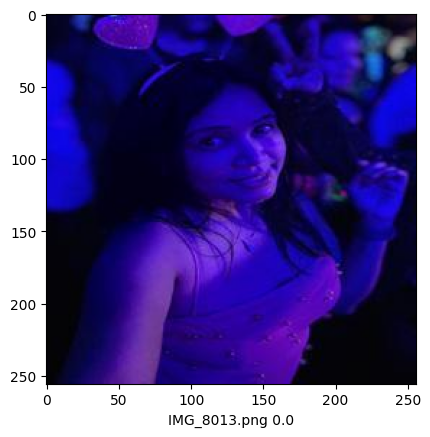

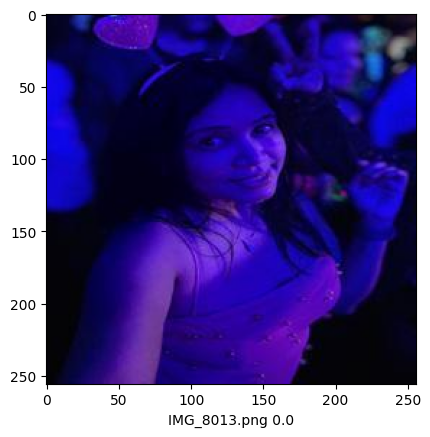

In [144]:
def compute_similar_images(image, num_images, embedding, device, all_images):

    image_tensor = image.unsqueeze(0)
    
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

    if embedding.ndim > 2:
        embedding = embedding.reshape(embedding.shape[0], -1)

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)
    distances, indices = knn.kneighbors(flattened_embedding)

    similar_images = []

    indices = indices[0].tolist()
    distances = distances[0].tolist()

    # print(distances)

    if len(distances) == len(all_images):
        print("Lengths are equal")
    
    match = []
    for i in range(len(distances)):
        match.append((all_images[i], distances[i]))
    
    print(match)

    distance = 0.01
    for i in range(len(distances)):
        if(distances[i] < distance):
            # image_name = all_images[indices[i]]
            # similar_images.append((image_name, indices[i], distances[i]))
            similar_images.append((all_images[indices[i]],indices[i], distances[i]))

    return similar_images


i = 0
folder = "Photos-001"
sortedFolder = "sortedImages"
file_name = "IMG_8013.png"

all_images = os.listdir(folder)
print(all_images)
all_images.sort()
print(all_images)

image_path = os.path.join(folder, file_name)
new_path_name = f"Image_{str(i)}"
new_path = os.path.join(sortedFolder, new_path_name)
if os.path.exists(new_path):
    shutil.rmtree(new_path)
os.makedirs(new_path)

def process(filename, file, distance):
    text_label = filename + " " + str(distance)
    image = mpimg.imread(file)
    plt.figure()
    plt.xlabel(text_label)
    plt.imshow(image)

image = Image.open(image_path).convert("RGB")
image = transforms(image)




process(file_name, image_path, 0.0)

output = compute_similar_images(image, len(all_images), embedding, device, all_images)
print(output)
if len(output) == 0:
    print("No similar images found")
else: 
    for name,number,distance in output:
        # image_path = os.path.join(folder, )
        print(name, number, distance)
        image_path = os.path.join(folder, name)
        process(name, image_path, distance)

new_path_name = f"Image_{str(i)}"